### Student Information
Name: 連音祺

Student ID: 111070005

GitHub ID: roseeeea

Kaggle name: YinChiLien 111070005

Kaggle private scoreboard snapshot: 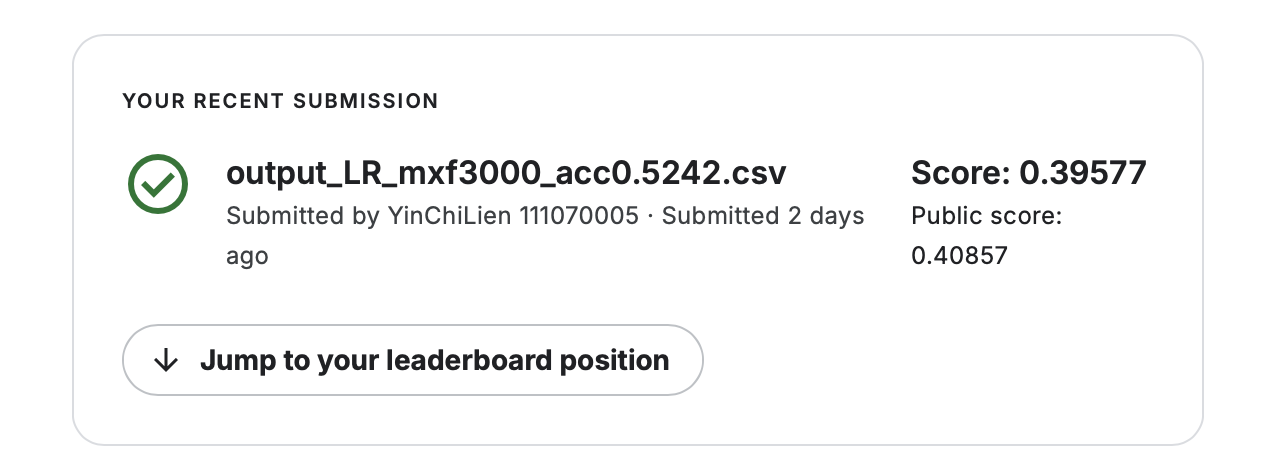


---
#DM Lab2 homework -- Kaggle competition
name: 111070005 連音祺

---

## (1) Import Related Library

In [ ]:
!pip3 install scikit-learn --upgrade
!pip3 install pandas --upgrade
!pip3 install numpy --upgrade
!pip3 install matplotlib --upgrade
!pip3 install plotly --upgrade
!pip3 install seaborn --upgrade
!pip3 install nltk --upgrade
!pip3 install umap-learn --upgrade

!pip3 install gensim --upgrade
#!pip3 install tensorflow --upgrade
!pip3 install tensorflow==2.17.0
!pip3 install keras --upgrade

!pip3 install ollama --upgrade
!pip3 install langchain --upgrade
!pip3 install langchain_community --upgrade
!pip3 install langchain_core --upgrade
!pip3 install beautifulsoup4 --upgrade
!pip3 install chromadb --upgrade
!pip3 install gradio --upgrade

In [ ]:
#Download ollama
!curl -fsSL https://ollama.com/install.sh | sh
import subprocess
process = subprocess.Popen("ollama serve", shell=True) #runs on a different thread

In [ ]:
#Download model llama 3.2:1b
!ollama pull llama3.2:1b

In [ ]:
#Download model llama 3.2
!ollama pull llama3.2

In [ ]:
#Download model llava-phi3
!ollama pull llava-phi3

In [ ]:
# import library
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import umap
import gensim
import tensorflow
import keras
import ollama
import langchain
import langchain_community
import langchain_core
import bs4
import chromadb
import gradio

%matplotlib inline

print("gensim: " + gensim.__version__)
print("tensorflow: " + tensorflow.__version__)
print("keras: " + keras.__version__)

gensim: 4.3.3
tensorflow: 2.17.0
keras: 3.7.0


---
## (2) Load data


Firstly I download the dataset from kaggle and upload to the google colab.
Since the json file comprises multiple objects, I need to use for loop to get all the data.

In [2]:
import json

data = []
with open('tweets_DM.json', 'r') as file:
    for line in file:
        try:
            data.append(json.loads(line))  # 每行是一個單獨的 JSON 物件
        except json.JSONDecodeError as e:
            print(f"Error decoding line: {line}")

'''
with open('tweets_DM.json', 'r') as file:
    data = json.load(file)  # 載入成列表
'''


"\nwith open('tweets_DM.json', 'r') as file:\n    data = json.load(file)  # 載入成列表\n"

Check the number of data to ensure that data is loaded successfully. Total data is 1867535. From the data, we can see each object includes:
 - score
 - index
 - _source
  - tweet
  - hashtags
  - tweet_id
  - text
 - crawldata
 - _type

In [3]:
#check how many data (1867535)
print(len(data))
print(data[0].keys())
print(json.dumps(data[0], indent=4))

1867535
dict_keys(['_score', '_index', '_source', '_crawldate', '_type'])
{
    "_score": 391,
    "_index": "hashtag_tweets",
    "_source": {
        "tweet": {
            "hashtags": [
                "Snapchat"
            ],
            "tweet_id": "0x376b20",
            "text": "People who post \"add me on #Snapchat\" must be dehydrated. Cuz man.... that's <LH>"
        }
    },
    "_crawldate": "2015-05-23 11:42:47",
    "_type": "tweets"
}


---
## (3) Preprocess

### **Extract data:**
Extract the required information from the data, including:
 - tweet ID
 - text
 - hashtags (I think it may be useful)

and convert it into a DataFrame.

In [4]:
import pandas as pd

rows = []
for record in data:
    rows.append({
        "tweet_id": record['_source']['tweet']['tweet_id'],
        "hashtags": record['_source']['tweet']['hashtags'],
        "tweet_text": record['_source']['tweet']['text'],
    })

df = pd.DataFrame(rows)
print(df[0:3])

   tweet_id                       hashtags  \
0  0x376b20                     [Snapchat]   
1  0x2d5350  [freepress, TrumpLegacy, CNN]   
2  0x28b412                   [bibleverse]   

                                          tweet_text  
0  People who post "add me on #Snapchat" must be ...  
1  @brianklaas As we see, Trump is dangerous to #...  
2  Confident of your obedience, I write to you, k...  


### **Merge the data indentification and emotion labels**
Using the tweet_id column as a key, the code performs two sequential left joins to merge these supplementary datasets with the original data.

 (I print the data type of the tweet_id column in the original dataset to ensure compatibility for further application. )

In [5]:
#add emotion label and identification
emotion_df = pd.read_csv('emotion.csv')
identification_df = pd.read_csv('data_identification.csv')

df_with_emotion = pd.merge(df, emotion_df, on='tweet_id', how='left')
df_unpreprocessed = pd.merge(df_with_emotion, identification_df, on='tweet_id', how='left')

print(df['tweet_id'].dtype)

object


check if the merge is successful.

In [ ]:
tweet_id = '0x376b20'
print(emotion_df[emotion_df['tweet_id'] == tweet_id])
print(identification_df[identification_df['tweet_id'] == tweet_id])
print(df_unpreprocessed[df_unpreprocessed['tweet_id'] == tweet_id])

         tweet_id       emotion
1205566  0x376b20  anticipation
        tweet_id identification
193653  0x376b20          train
   tweet_id    hashtags                                         tweet_text  \
0  0x376b20  [Snapchat]  People who post "add me on #Snapchat" must be ...   

        emotion identification  
0  anticipation          train  


### **Split the data**
splitting the preprocessed dataset into training and testing subsets based on the identification column.

In [6]:
# split validation and train
from sklearn.model_selection import train_test_split

Train_df = df_unpreprocessed[df_unpreprocessed['identification'] == 'train']
test_df = df_unpreprocessed[df_unpreprocessed['identification'] == 'test']


check if there are any invalid values.

In [ ]:
Train_df.isnull().sum()

,0
tweet_id,0
hashtags,0
tweet_text,0
emotion,0
identification,0


Here, we utilize the code in lab2 Master to have a simple EDA. I want to see the distribution of current dataset using bar plot to investigate whether the data is balanced.

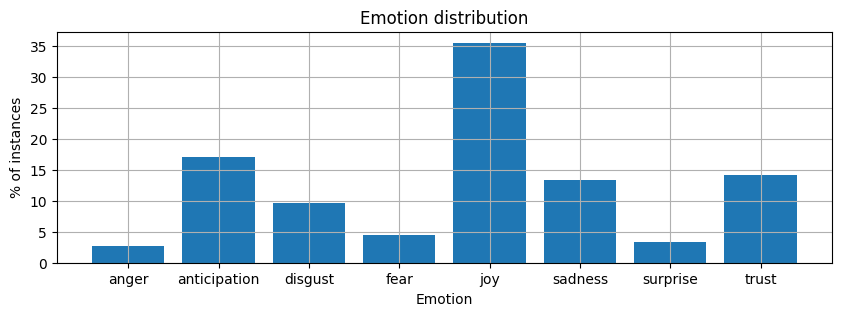

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# the histogram of the data
labels = Train_df['emotion'].unique()
post_total = len(Train_df)
df1 = Train_df.groupby(['emotion']).count()['tweet_text']
df1 = df1.apply(lambda x: round(x*100/post_total,3)) #3->round to 3 digits

#plot
fig, ax = plt.subplots(figsize=(10,3))
plt.bar(df1.index,df1.values)

#arrange
plt.ylabel('% of instances')
plt.xlabel('Emotion')
plt.title('Emotion distribution')
plt.grid(True)
plt.show()

From the plot, we can see in this dataset, the emotion of "Joy" is exceptionally high (about 35*), while other only stands for below 20%.
Overall structure is imbalanced.

In order to understand the current model pridiction power, I split my training data to train and validation dataset.

In [9]:
train_df, val_df = train_test_split(Train_df, test_size=0.2, random_state=42)

### **Convert text to vector**


To let the further model training more efficient, I let the data to be tokenized first. I use two way to tranform my text data:

- BOW + TFIDF : I use it as a baseline of our model.
  - advantages: it is simple and efficient
  - parameter: max_features: 3000, since the data is large, and I don't want to wait for too long...
- BERT : to compared with the performance of domain independence vectorizer.
 - advantages: good Contextual Understanding, can understand more rare words.

#### **-> BOW + TFIDF**

 - I choose to use **nltk** as my tokenizer, **because nltk can intepret more unusual symbol**, such as sad emoji, and in real life, the emoji can really present our feeling, which is highly associated with "emotion" label.
 - use train df (not Train df) as corpus to simulate real scenerio

In [7]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

The  competition I use **max_features =3000.**

After the competition, I test another two number(1000 and 5000) to define which number is the best. Please see the **final result** part.

In [21]:
BOW = TfidfVectorizer(tokenizer=nltk.word_tokenize, max_features=5000) #1000, 3000, 5000
BOW.fit(train_df['tweet_text'])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


TfidfVectorizer(max_features=5000,
                tokenizer=<function word_tokenize at 0x78af58ae77f0>)

In [22]:
x_train = BOW.transform(train_df['tweet_text'])
y_train = train_df['emotion']
x_val = BOW.transform(val_df['tweet_text'])
y_val = val_df['emotion']
x_test = BOW.transform(test_df['tweet_text'])

#### **-> BERT**
Another method I want to try is using BERT, for the reaso that it can interpret deeper semantic meaning, which may help analyze the tweet text.

In [ ]:
!pip install transformers datasets

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
le = LabelEncoder()
y_train_encoded = le.fit_transform(train_df['emotion'])
y_val_encoded = le.transform(val_df['emotion'])

---
## (4) Model Training

### **1. desicion tree + BOW**
#### the reasons I choose DT:
 - easy and basic
 - do not need too much preprocess


#### try and error:
 - experiment result: ***unsuccess*** (wait for 1 hrs and break down)
 - possible reasons: the data is too big to proccess.

In [ ]:
#build and train
from sklearn.tree import DecisionTreeClassifier

DT_model = DecisionTreeClassifier(random_state=1)
DT_model.fit(x_train, y_train)

In [ ]:
#predict
y_val_pred = DT_model.predict(x_val)

In [ ]:
#evaluate
from sklearn.metrics import f1_score

f1 = f1_score(y_val, y_val_pred)
print(f"F1 Score: {f1}")

In [ ]:
#output
output = pd.DataFrame({'id': test_df['tweet_id'], 'emotion': y_test_pred})
output.to_csv('output_DT_f1=.csv', index=False)

###  **2. naive bayes**
The reasons I choose NB:
 - good for handling high dimensional data, like text
 - easy and basic
 - do not need too much preprocess

try and error: (max_features =3000)
 - experiment result: ***accuracy=0.4894(kaggle F1=0.35)***
 - the result is not that good but can still serve as the baseline of performance
 - the potential reasons for poor performance:
  - the words across different emotions may overlapped, causing dependency.


In [23]:
#build and train
from sklearn.naive_bayes import MultinomialNB

NB_model = MultinomialNB()
NB_model.fit(x_train, y_train)

MultinomialNB()

In [24]:
#predict
y_val_pred = NB_model.predict(x_val)

In [25]:
#evaluate
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_val, y_val_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.4998


In [ ]:
y_test_pred = NB_model.predict(x_test)

In [ ]:
#output
output = pd.DataFrame({'id': test_df['tweet_id'], 'emotion': y_test_pred})
output.to_csv('output_NB_mxf3000_ac=0.49.csv', index=False)

### **3. XGboost**
The reasons I choose XG:
- it can handle big dataset
- it can emphasize important feature
- usually can reach high accuracy

try and error: max_features =3000
  - n_estimaters=20,***accuracy=0.4895 (kaggle F1=0.338)***
  - n_estimaters=30, ***accuracy=0.4981 (kaggle F1=0.323)***
  - the performance is far lower than expected, strangly the accuracy is higher than NB but F1 score indicates differently.
  - potential reasons:
   - class imbalance: some emotion may significantly more than other.
     - scale_pos_weight (Argh.... no time to try...:(
     - n_estimator too small  (Argh.... no time to try...:(
     - unsuitable threhold : current threhold is 0.5, we can try something else (no time !!!! X( )


In [26]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
le = LabelEncoder()

# Fit the encoder to your training labels and transform them
y_train_encoded = le.fit_transform(y_train)

XG_model = XGBClassifier(random_state=42, n_estimators=30, subsample=0.9, objective='multi:softmax', num_class=8 )
XG_model.fit(x_train, y_train_encoded)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=30, n_jobs=None, num_class=8,
              num_parallel_tree=None, ...)

In [27]:
y_val_pred = XG_model.predict(x_val)
y_val_pred_decoded = le.inverse_transform(y_val_pred)

In [28]:
#evaluate
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_val, y_val_pred_decoded)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.5003


In [ ]:

y_test_pred = XG_model.predict(x_test)
y_test_pred_decoded = le.inverse_transform(y_test_pred)

In [ ]:
#output
output = pd.DataFrame({'id': test_df['tweet_id'], 'emotion': y_test_pred_decoded})
output.to_csv('output_XG_mxf3000_42_30_0.9_acc=0.4981.csv', index=False)

### **5. Logistic Regression**
the reasons I choose LR:
 - fast and easy
 - good for high dimension sparse data

try and error: (max_features =3000)
 - ***accuracy=0.5242 (kaggle F1=0.408)***
 - current best result, this implies there may be some linear relation between emotions.


In [29]:
from sklearn.linear_model import LogisticRegression

LR_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500, random_state=42)
LR_model.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=500, multi_class='multinomial', random_state=42)

In [30]:
y_val_pred = LR_model.predict(x_val)

In [31]:
#evaluate
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_val, y_val_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.5351


In [ ]:
y_test_pred = LR_model.predict(x_test)

In [ ]:
#output
output = pd.DataFrame({'id': test_df['tweet_id'], 'emotion': y_test_pred})
output.to_csv('output_LR_mxf3000_acc=0.5242.csv', index=False)

### **6. BERT**
the reasons I choose BERT:
 - want to compared the performance with local domain vect.
 - it can interpret more complicate semantic.

try and error:
 - ***unfinished***, since I still can not fixed the label problem, it can not run.

In [ ]:
!pip install datasets

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from datasets import Dataset
import torch

# 加載 BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# 構建數據集
def tokenize_function(examples):
    return tokenizer(
        examples["tweet_text"],
        padding='max_length',  # Pad to the maximum length in the batch
        truncation=True,       # Truncate if exceeds max_length
        max_length=128         # Set a maximum sequence length
    )

train_data = Dataset.from_dict({"tweet_text": train_df['tweet_text'], "emotion": y_train_encoded})
val_data = Dataset.from_dict({"tweet_text": val_df['tweet_text'], "emotion": y_val_encoded})

train_data = train_data.map(tokenize_function, batched=True)
val_data = val_data.map(tokenize_function, batched=True)


Map:   0%|          | 0/1164450 [00:00<?, ? examples/s]

Map:   0%|          | 0/291113 [00:00<?, ? examples/s]

In [ ]:
# 加載模型（分類任務，num_labels 為類別數）
train_data = train_data.rename_column("emotion", "labels")
val_data = val_data.rename_column("emotion", "labels")

# 設置格式為 torch
train_data.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
val_data.set_format("torch", columns=["input_ids", "attention_mask", "labels"])


model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(le.classes_))

ValueError: Original column name emotion not in the dataset. Current columns in the dataset: ['tweet_text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask']

In [ ]:
from transformers import TrainingArguments, Trainer

# 訓練參數
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

# 定義 Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
)

# Update dataset to include labels column
train_data = train_data.rename_column("emotion", "labels")
val_data = val_data.rename_column("emotion", "labels")

# Set the format to torch for the labels column
train_data.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
val_data.set_format("torch", columns=["input_ids", "attention_mask", "labels"])


# 開始訓練
trainer.train()


ValueError: The model did not return a loss from the inputs, only the following keys: logits. For reference, the inputs it received are input_ids,token_type_ids,attention_mask.

In [ ]:
results = trainer.evaluate()
print("Evaluation results:", results)

In [ ]:
import pandas as pd
import torch

# 將 test_encoded 轉換為 Dataset 格式
test_data = Dataset.from_dict({"tweet_text": test_df['tweet_text']})
test_data = test_data.map(tokenize_function, batched=True)


y_test_pred = trainer.predict(test_data)
predicted_class_indices = torch.argmax(torch.tensor(y_test_pred.predictions), dim=1).numpy()

# 將數字標籤轉回原始類別
predicted_labels = le.inverse_transform(predicted_class_indices)


In [ ]:
#output
output = pd.DataFrame({'id': test_df['tweet_id'], 'emotion': predicted_labels})
output.to_csv('output_BERT_42_30_0.9_acc=.csv', index=False)

---
# Result
### - **kaggle**
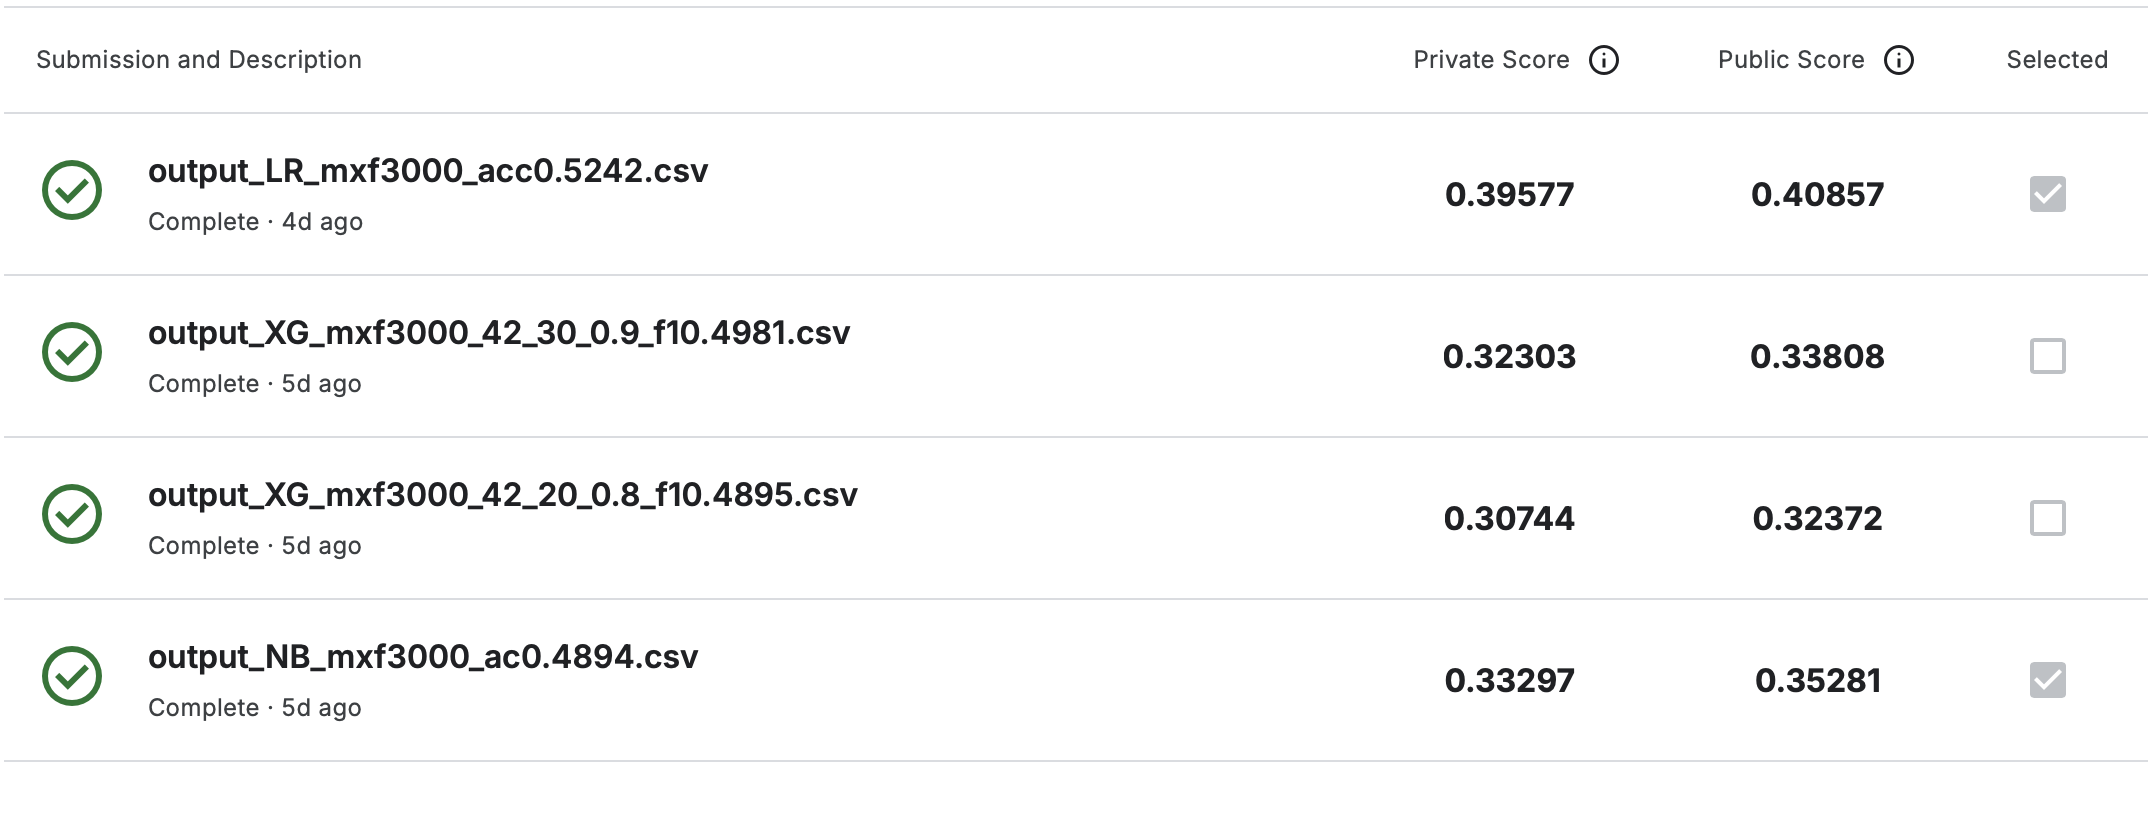

 ### **- Maxfeature experiment**
test after competition, so there are no F1 score, only **accuracy**

In [32]:
import pandas as pd

data = {
    'MaxFeature': [1000, 3000, 5000],
    'NB': [0.4584, 0.4894, 0.4998],
    'XG(n=30)': [0.4856, 0.4981, 0.5003],
    'LR': [0.4883, 0.5242, 0.5351]
}

# 創建 DataFrame
df = pd.DataFrame(data)

# 顯示表格
df.set_index('MaxFeature', inplace=True)
df

,NB,XG(n=30),LR
MaxFeature,,,
1000,0.4584,0.4856,0.4883
3000,0.4894,0.4981,0.5242
5000,0.4998,0.5003,0.5351
